# Model Based Collaborative Filtering Recommender

The goal of the **recommender system** is to predict user preference for a set of items based on the past experience. Two the most popular approaches are Content-Based and Collaborative Filtering.

**Collaborative filtering** is a technique used by websites like Amazon, YouTube, and Netflix. It filters out items that a user might like on the basis of reactions of similar users. There are two categories of collaborative filtering algorithms: memory based and model based.

**Model based approach** involves building machine learning algorithms to predict user's ratings. They involve dimensionality reduction methods that reduce high dimensional matrix containing abundant number of missing values with a much smaller matrix in lower-dimensional space.

The goal of this exercise is to compare SVD and NMF algorithms, try different configurations of parameters and explore obtained results.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import Dataset, Reader
from surprise import SVD, NMF
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

import functions as f

This analysis will focus on book recommendations based on [Book-Crossing dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). To reduce the dimensionality of the dataset and avoid running into memory error it will focus on users with at least 3 ratings and top 10% most frequently rated books. It consists of 176,594 records.

The recommender systems will be built using [surprise package](https://surprise.readthedocs.io/en/stable/getting_started.html) (Matrix Factorization - based models).

In [2]:
df = pd.read_csv('data/ratings_top.csv')

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['user_id', 'isbn', 'book_rating']], reader)

In [3]:
print('Number of ratings: %d\nNumber of books: %d\nNumber of users: %d' % (len(df), len(df['isbn'].unique()), len(df['user_id'].unique())))

Number of ratings: 176594
Number of books: 16766
Number of users: 20149


## SVD and NMF models comparison

Singular Value Decomposition (SVD) and Non-negative Matrix Factorization (NMF) are matrix factorization techniques used for dimensionality reduction. Surprise package provides implementation of those algorithms.

It's clear that for the given dataset much better results can be obtained with SVD approach - both in terms of accuracy and training / testing time.

In [15]:
model_svd = SVD()
cv_results_svd = cross_validate(model_svd, data, cv=3)
pd.DataFrame(cv_results_svd).mean()

test_rmse     1.606926
test_mae      1.242338
fit_time     18.130412
test_time     1.120190
dtype: float64

In [16]:
model_nmf = NMF()
cv_results_nmf = cross_validate(model_nmf, data, cv=3)
pd.DataFrame(cv_results_nmf).mean()

test_rmse     2.640803
test_mae      2.255504
fit_time     22.795353
test_time     1.005285
dtype: float64

## Optimisation of SVD algorithm

Grid Search Cross Validation computes accuracy metrics for an algorithm on various combinations of parameters, over a cross-validation procedure. It's useful for finding the best configuration of parameters.

It is used to find the best setting of parameters:
* n_factors - the number of factors
* n_epochs - the number of iteration of the SGD procedure
* lr_all - the learning rate for all parameters
* reg_all - the regularization term for all parameters

As a result, regarding the majority of parameters, the default setting is the most optimal one. The improvement obtained with Grid Search is very small.

In [17]:
param_grid = {'n_factors': [80,100,120],
              'n_epochs': [5, 10, 20],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.2, 0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

#1.5981785240945765
#{'n_factors': 80, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}

1.5981785240945765
{'n_factors': 80, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


## Analysis of Collaborative Filtering model results

In this part, let's examine in detail the results obtained by the SVD model that provided the best RMSE score.

In [4]:
trainset, testset = train_test_split(data, test_size=0.2)

model = SVD(n_factors=80, n_epochs=20, lr_all=0.005, reg_all=0.2)
model.fit(trainset)
predictions = model.test(testset)

In [5]:
df_pred = pd.DataFrame(predictions, columns=['user_id', 'isbn', 'actual_rating', 'pred_rating', 'details'])

df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['pred_rating_round'] = df_pred['pred_rating'].round()
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)

df_pred.sample(5)

,user_id,isbn,actual_rating,pred_rating,impossible,pred_rating_round,abs_err
6118,242999,0345374568,5.0,7.246858,False,7.0,2.246858
17185,67840,155166951X,10.0,8.513183,False,9.0,1.486817
21313,78553,0451404327,10.0,9.083398,False,9.0,0.916602
23423,107784,0373031467,5.0,5.890978,False,6.0,0.890978
9899,95250,0375725601,9.0,8.035049,False,8.0,0.964951


### Distribution of actual and predicted ratings in the test set

According to the distribution of actual ratings of books in the test set, the biggest part of users give positive scores - between 7 and 10. The mode equals 8 but count of ratings 7, 9, 10 is also noticeable. The distribution of predicted ratings in the test set is visibly different. One more time, 8 is a mode but scores 7, 9 and 10 are clearly less frequent.

It shows that the recommender system is not perfect and it cannot reflect the real distribution of book ratings.

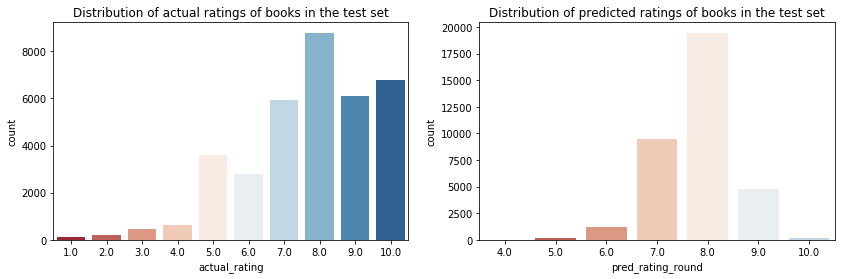

In [6]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of books in the test set')

sns.countplot(x='pred_rating_round', data=df_pred, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of books in the test set')

plt.show()

### Absolute error of predicted ratings

The distribution of absolute errors is right-skewed, showing that the majority of errors is small: between 0 and 1. There is a long tail that indicates that there are several observations for which the absolute error was close to 10.

How good/bad the model is with predicting certain scores? As expected from the above charts, the model deals very well with predicting score = 8 (the most frequent value). The further the rating from score = 8, the higher the absolute error. The biggest errors happen to observations with scores 1 or 2 which indicates that probably the model is predicting high ratings for those observations.

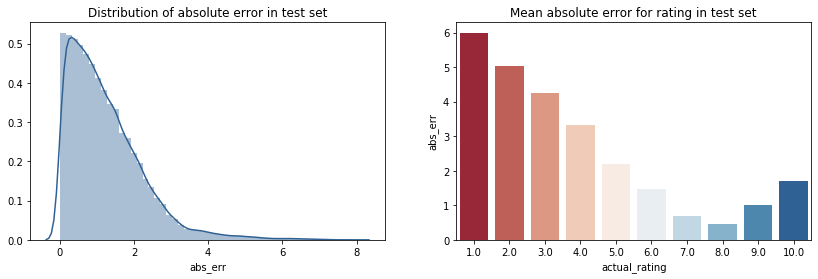

In [7]:
df_pred_err = df_pred.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()

### Analysis of predicted ratings of a particular user

For this part of the analysis, the user with id 193458 was selected. By analyzing book ratings by this user, it can be noted that he/she likes diverse types of readings: English romantic novels (Pride and Prejudice, Sense and Sensibility), fantasy (Narnia) as well as historical novels (Schindler's List). Among the recommended books there are other works from Narnia's series, two historical novels and one romance which correlates with user's previous preferences.

In [17]:
df_books = pd.read_csv('data/books.csv')

df_ext = df.merge(df_books[['isbn', 'book_title']], on='isbn', how='left')
df_ext['book_title_short'] = df_ext['book_title'].apply(f.short_title)
df_ext = df_ext.merge(df_pred[['isbn', 'user_id', 'pred_rating']], on=['isbn', 'user_id'], how='left')

In [11]:
selected_user_id = 193458
df_user = df_ext[df_ext['user_id']==selected_user_id]

df_user[(df_user['pred_rating'].isna())&(df_user['book_rating']>=9)].sample(10)

,user_id,isbn,book_rating,book_title,book_title_short,pred_rating
124989,193458,1853260002,10,Pride &amp; Prejudice (Wordsworth Classics),Pride &amp; Prejudice (Wordsworth Classics),NaN
124942,193458,0140620125,9,Wuthering Heights (Penguin Popular Classics),Wuthering Heights (Penguin Popular Classics),NaN
124952,193458,0345342569,9,Shoeless Joe,Shoeless Joe,NaN
124940,193458,0140298479,9,Bridget Jones: The Edge of Reason,Bridget Jones: The Edge of Reason,NaN
124991,193458,1853260169,10,Sense and Sensibility (Wordsworth Classics),Sense and Sensibility (Wordsworth Classics),NaN
124978,193458,0671880314,9,Schindler's List,Schindler's List,NaN
124951,193458,0330352695,9,Four Letters of Love,Four Letters of Love,NaN
124932,193458,0064471047,9,"The Lion, the Witch, and the Wardrobe (The Chr...","The Lion, the Witch, and the Wardrobe (The",NaN
124938,193458,0064471101,9,The Magician's Nephew (rack) (Narnia),The Magician's Nephew (rack) (Narnia),NaN
124936,193458,006447108X,9,The Last Battle,The Last Battle,NaN


### Train set: Top rated books

![](img/train_actual.jpg)

In [12]:
df_user[df_user['pred_rating'].notna()].sort_values('pred_rating', ascending=False).head(5)

,user_id,isbn,book_rating,book_title,book_title_short,pred_rating
124946,193458,0142001740,9,The Secret Life of Bees,The Secret Life of Bees,8.281881
124935,193458,0064471071,9,The Voyage of the Dawn Treader (rack) (Narnia),The Voyage of the Dawn Treader (rack) (Narnia),8.244509
124937,193458,0064471098,9,The Silver Chair,The Silver Chair,8.184727
124974,193458,0553258001,9,The Cider House Rules,The Cider House Rules,8.057183
124958,193458,0345431057,9,Slaves in the Family (Ballantine Reader's Circle),Slaves in the Family (Ballantine Reader's,8.055557


### Test set: predicted top rated books

![](img/test_pred.jpg)

In [13]:
df_user[df_user['pred_rating'].notna()].sort_values('book_rating', ascending=False).head(5)

,user_id,isbn,book_rating,book_title,book_title_short,pred_rating
124934,193458,0064471063,9,The Horse and His Boy,The Horse and His Boy,7.814202
124935,193458,0064471071,9,The Voyage of the Dawn Treader (rack) (Narnia),The Voyage of the Dawn Treader (rack) (Narnia),8.244509
124937,193458,0064471098,9,The Silver Chair,The Silver Chair,8.184727
124946,193458,0142001740,9,The Secret Life of Bees,The Secret Life of Bees,8.281881
124958,193458,0345431057,9,Slaves in the Family (Ballantine Reader's Circle),Slaves in the Family (Ballantine Reader's,8.055557


### Test set: actual top rated books

![](img/test_actual.jpg)